In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

2023-11-20 16:50:55.881852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from koopmanlib.functions import *

In [5]:
import json
import sys

# Generate data

In [6]:
config_file = 'config_fhn.json'

In [7]:
with open(config_file, 'r') as f:
    config = json.load(f)['fhn_settings']

In [8]:
data_path = config['data_settings']['data_path']
weights_path = config['nn_settings']['weights_path']

In [9]:
Nx = config['data_settings']['Nx']
n_traj = config['data_settings']['n_traj']
traj_len = config['data_settings']['traj_len']

In [10]:
n_psi_train = config['nn_settings']['n_psi_train']
target_dim = Nx*2
param_dim = 1
n_psi = 1 + target_dim + n_psi_train
dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size = config['nn_settings']['K_layer_size']

In [11]:
x = np.linspace(-10,10,Nx)
t = np.arange(0, traj_len, 1)

In [12]:
from koopmanlib.target import FitzHughNagumoTarget

In [13]:
fhn_pde = FitzHughNagumoTarget(
            x=x,
            dt=1e-5,
            t_step=1e-3,
            dim=target_dim,
            param_dim=param_dim,
            param_input=1e3)

In [14]:
data_dict = np.load(os.path.join(data_path, 'data_fhn_Nx_'+str(Nx)+'.npy'), allow_pickle=True)

In [15]:
data_z_curr = data_dict[()]['data_z_curr']
data_u = data_dict[()]['data_u']
data_z_next = data_dict[()]['data_z_next']

In [16]:
data_z_curr.shape

(49900, 20)

In [17]:
data_z_curr_reshape = data_z_curr.reshape(-1,n_traj,target_dim)
data_z_curr_reshape_trans = np.transpose(data_z_curr_reshape, (1,0,2))
sample_idx = 1

In [18]:
from sklearn.preprocessing import StandardScaler
scaler_z = StandardScaler()
scaler_z.fit(data_z_curr)

z_curr_normalized = scaler_z.transform(data_z_curr)
z_next_normalized = scaler_z.transform(data_z_next)

# After the prediction, we use inverse_transform to recover data.

# z_curr_recover = scaler_z.inverse_transform(z_curr_normalized)

# Build model

In [19]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [20]:
from tensorflow.keras.optimizers import Adam

In [21]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [22]:
from koopmanlib.K_structure import Model_K_u_Layer

model_K_u = Model_K_u_Layer(layer_sizes=K_layer_size, 
                                n_psi=n_psi)

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, 
    param_dim=param_dim, 
    n_psi=n_psi, 
    dic=dic_pk, 
    model_K_u=model_K_u)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

In [23]:
model_pk.load_weights(os.path.join(weights_path, 'norm_psi_'+str(n_psi_train)+'_model_pk_fhn_Nx_'+str(Nx)+'.h5'))

# Prediction

In [51]:
n_traj_test = 1
traj_len_test = 500

In [54]:
data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(target=fhn_pde,
                                                                               scaler=scaler_z,
                                                                               solver=solver_pk,
                                                                               n_traj=n_traj_test,
                                                                               traj_len=traj_len_test,
                                                                               seed_z=11,
                                                                               seed_param=11)

In [55]:
data_true_normalized.shape, data_pred_pk_normalized.shape, z_curr_ori.shape

((499, 20), (499, 20), (499, 20))

In [56]:
x_axis = x
y_axis = np.arange(0, data_true_normalized.shape[0], 1)

In [57]:
ratio_pk_normalized = compute_diff_ratio_one_traj(data_true_normalized, 
                                    data_pred_pk_normalized)

In [58]:
data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)

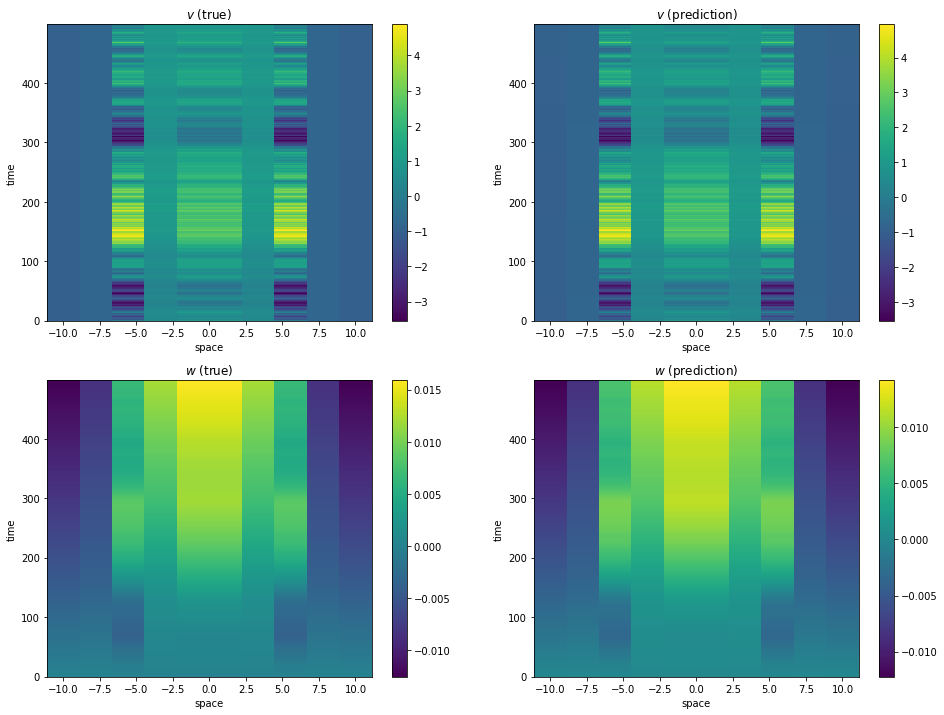

In [59]:
plot_pde_comparison(x_axis=x_axis,
                    y_axis=y_axis, 
                    data_true=z_curr_ori, 
                    data_pred=data_pred_pk_recover,
                    Nx=Nx)

In [60]:
ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, 
                                    data_pred_pk_recover)

In [61]:
data_pred_pk_normalized.shape

(499, 20)

# RBF + Ploynomial K (1, $u, u^2, u^3$)

In [62]:
from koopmanlib.dictionary import DicGaussianRBF

dic_rbf_fhn = DicGaussianRBF(rbf_number=n_psi_train, s=1/20)

dic_rbf_fhn.build(z_curr_normalized)

from koopmanlib.param_solver import KoopmanActuatedDLSolver

solver_rbf = KoopmanActuatedDLSolver(dic=dic_rbf_fhn, 
                                     target_dim=target_dim, 
                                     param_dim=param_dim, 
                                     n_psi=n_psi, 
                                     basis_u_func=fhn_pde.basis_u_func)

model_rbf = solver_rbf.build_model()

model_rbf_opt = solver_rbf.opt_rbf_model(data_x=z_curr_normalized,
                                 data_u=data_u,
                                 data_y=z_next_normalized)

In [63]:
data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(target=fhn_pde,
                                                                                scaler=scaler_z,
                                                                                solver=solver_rbf,
                                                                                n_traj=n_traj_test,
                                                                                traj_len=traj_len_test,
                                                                                seed_z=11,
                                                                                seed_param=11)

In [64]:
ratio_rbf_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_rbf_normalized)

In [65]:
# Original space
data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)

In [66]:
data_pred_rbf_recover.shape

(499, 20)

In [67]:
ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, 
                                    data_pred_rbf_recover)

# DL + Polynomial K (1, $u, u^2, u^3$)

In [69]:
dic_dl_polyK = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

solver_dl_polyK = KoopmanActuatedDLSolver(dic=dic_dl_polyK, 
                                         target_dim=target_dim,
                                         param_dim=param_dim,
                                         n_psi=n_psi, 
                                         basis_u_func=fhn_pde.basis_u_func)

model_dl_polyK = solver_dl_polyK.build_model()

In [70]:
solver_dl_polyK.model.load_weights(os.path.join(weights_path,'norm_psi_'+str(n_psi_train)+'_model_dl_polyK_fhn_Nx_'+str(Nx)+'.h5'))

In [71]:
data_true_normalized, data_pred_dl_polyK_normalized, z_curr_ori = recover_prediction(target=fhn_pde,
                                                                                     scaler=scaler_z,
                                                                                     solver=solver_dl_polyK,
                                                                                     n_traj=n_traj_test,
                                                                                     traj_len=traj_len_test,
                                                                                     seed_z=11,
                                                                                     seed_param=11)

In [72]:
ratio_dl_polyK_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_dl_polyK_normalized)

In [73]:
# Original space
data_pred_dl_polyK_recover = scaler_z.inverse_transform(data_pred_dl_polyK_normalized)

In [74]:
ratio_dl_polyK_recover = compute_diff_ratio_one_traj(z_curr_ori, 
                                    data_pred_dl_polyK_recover)

# Average Prediction

In [75]:
np.random.seed(111)
n_test = 10
seed_z_list = np.random.randint(1,300, size=(n_test,))
seed_param_list = np.random.randint(1,300, size=(n_test,))

n_traj_test = 1

x_axis = x
y_axis = np.arange(0, traj_len_test-1, 1)

In [79]:
ratio_pk_list = []
ratio_rbf_list = []
ratio_dl_polyK_list = []

for seed_z, seed_param in zip(seed_z_list, seed_param_list):
    
    data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(target=fhn_pde,
                                                                               scaler=scaler_z,
                                                                               solver=solver_pk,
                                                                               n_traj=n_traj_test,
                                                                               traj_len=traj_len_test,
                                                                               seed_z=seed_z,
                                                                               seed_param=seed_param)
    
    data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(target=fhn_pde,
                                                                                scaler=scaler_z,
                                                                                solver=solver_rbf,
                                                                                n_traj=n_traj_test,
                                                                                traj_len=traj_len_test,
                                                                                seed_z=seed_z,
                                                                                seed_param=seed_param)
    
    data_true_normalized, data_pred_dl_polyK_normalized, z_curr_ori = recover_prediction(target=fhn_pde,
                                                                                     scaler=scaler_z,
                                                                                     solver=solver_dl_polyK,
                                                                                     n_traj=n_traj_test,
                                                                                     traj_len=traj_len_test,
                                                                                     seed_z=seed_z,
                                                                                     seed_param=seed_param)
    
    data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)
    data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)
    data_pred_dl_polyK_recover = scaler_z.inverse_transform(data_pred_dl_polyK_normalized)


    
    ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_pk_recover)
    ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_rbf_recover)
    ratio_dl_polyK_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_dl_polyK_recover)



    ratio_pk_list.append(ratio_pk_recover)
    ratio_rbf_list.append(ratio_rbf_recover)
    ratio_dl_polyK_list.append(ratio_dl_polyK_recover)

ratio_pk_list = np.asarray(ratio_pk_list)
ratio_rbf_list = np.asarray(ratio_rbf_list)
ratio_dl_polyK_list = np.asarray(ratio_dl_polyK_list)



mean_pk, std_pk, mean_plus_pk, mean_minus_pk = compute_stat_info(ratio_pk_list)
mean_rbf, std_rbf, mean_plus_rbf, mean_minus_rbf = compute_stat_info(ratio_rbf_list)
mean_dl_polyK, std_dl_polyK, mean_plus_dl_polyK, mean_minus_dl_polyK = compute_stat_info(ratio_dl_polyK_list)

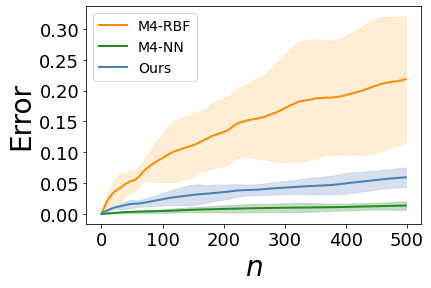

In [80]:
label_font = 16
ticks_font = 16
legend_font = 16
linewidth = 2

t_axis = np.arange(0, traj_len_test-1, 1)

plt.plot(mean_rbf, label='M4-RBF', color='darkorange', linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_rbf, mean_plus_rbf, color='navajowhite', alpha=0.5)

plt.plot(mean_dl_polyK, label='M4-NN', color='forestgreen', linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_dl_polyK, mean_plus_dl_polyK, color='darkseagreen', alpha=0.5)


plt.plot(mean_pk, label='Ours', color='steelblue', linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_pk, mean_plus_pk, color='lightsteelblue', alpha=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel(r'$n$', fontsize=28)
plt.ylabel('Error', fontsize=28)
plt.legend(fontsize=14)


In [81]:
dict_error = {'pk': ratio_pk_list,
             'rbf': ratio_rbf_list,
             'dl':ratio_dl_polyK_list}

In [82]:
# np.save(os.path.join(data_path, 'error_dict.npy'), dict_error)